In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import scipy
import scipy.stats
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

import astropy
import astropy.units as u
import astropy.constants as ac
import sunpy.map
import sunpy.visualization.colormaps as cm
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import random



%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

from pathlib import Path

import autoenc_model as aem
import data_generator as dg
import utils
import json

import umap

from mpl_toolkits.mplot3d import Axes3D

import ipywidgets as widgets
import open3d as o3d

import datetime
from tqdm.notebook import tqdm

/home/eugeniolr/anaconda3/envs/e_DL/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/eugeniolr/anaconda3/envs/e_DL/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/eugeniolr/anaconda3/envs/e_DL/lib/python3.10/site-packages/uma

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
latent_size = 1024
batch_size = 48
gen_input = dg.MultiChannelAEGenerator("data/composite_data/", batch_size, test_split=0.2, shuffle=False, noise_filter=True)

25650
19012


In [6]:
all_gen_input = dg.MultiChannelAEGenerator("data/composite_data/", batch_size, test_split=0, shuffle=False, noise_filter=False)
all_gen_input.take_all = True

/home/eugeniolr/Documents/master/TFM/data_generator.py:194: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:195: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:203: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)


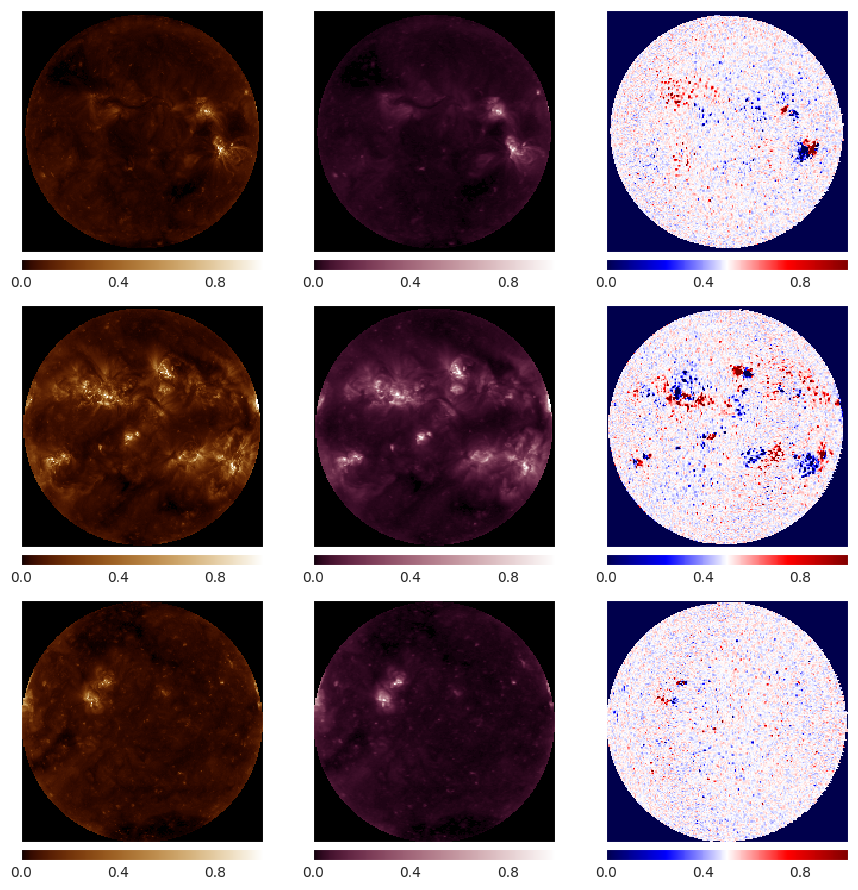

In [7]:
img_amount = 3

sample_images = gen_input.sample(img_amount)

image_list = []
for data_image in sample_images:
    for channel in data_image.transpose(2,0,1):
        image_list.append(channel)

isns.ImageGrid(image_list, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, orientation="h", vmin=0, vmax=1)


In [9]:
print("train using the script")
# latent_size = 1024
# # optimizer = keras.optimizers.Adam(learning_rate=0.001)
# # optimizer = keras.optimizers.SGD(learning_rate=0.01)
# optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

# loss_fn = "mse"

# autoencoder, encoder, decoder = aem.gen_xception_autoenc_3c(latent_size, optim=optimizer, loss=loss_fn)

train using the script


In [10]:
print("train using the script")
# n_epochs = 1

# history = autoencoder.fit(gen_input, epochs=n_epochs)

train using the script


In [11]:
print("train using the script")
# json_history_str = json.dumps(history.history)
# with open("AE_xception_full.json", "w") as j:
#     j.write(json_history_str)

train using the script


In [12]:
print("train using the script")
# autoencoder.save("autoencoder_xception.h5")
# encoder.save("encoder_xception.h5")
# decoder.save("decoder_xception.h5")

train using the script


In [13]:
# autoencoder = keras.models.load_model("autoencoder_768_xception.h5")
# encoder = keras.models.load_model("encoder_768_xception.h5")
# decoder = keras.models.load_model("decoder_768_xception.h5")

autoencoder = keras.models.load_model("autoencoder_VAE_1024_xception.h5")
encoder = keras.models.load_model("encoder_VAE_1024_xception.h5")
decoder = keras.models.load_model("decoder_VAE_1024_xception.h5")

2023-06-25 19:49:42.004313: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
weights = tf.constant([0.5,0.5,2])
def modified_mse(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(tf.reduce_mean(squared_difference, axis=(0,1,2)) * weights) # Note the `axis=-1`

In [ ]:
input_img = keras.Input(shape=[204,204,3])
outputs = decoder(encoder(input_img)[2])
autoencoder = keras.Model(input_img, outputs, name='vae')
optim = keras.optimizers.RMSprop(learning_rate=8e-5, clipnorm=1)

autoencoder.compile(optimizer=optim, loss=modified_mse)

In [ ]:
gen_input = dg.MultiChannelAEGenerator("data/composite_data/", batch_size, test_split=0.2, shuffle=False, noise_filter=True)
val_gen_input = dg.MultiChannelAEGenerator("data/composite_data/", batch_size, test_split=0.2, shuffle=False, noise_filter=True)

val_cut_point = int(len(gen_input.train_list)*0.15)
val_gen_input.train_list = gen_input.train_list[:val_cut_point]
gen_input.train_list = gen_input.train_list[val_cut_point:]

25650
19012
25650
19012


In [ ]:
gen_input.training = True
n_epochs = 100
ft_history = autoencoder.fit(gen_input, validation_data=val_gen_input, epochs=n_epochs)

Epoch 1/100
269/269 [==============================] - 102s 331ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 2/100
269/269 [==============================] - 87s 321ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 3/100
269/269 [==============================] - 87s 321ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 4/100
269/269 [==============================] - 89s 329ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/100
269/269 [==============================] - 87s 322ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/100
269/269 [==============================] - 88s 328ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/100
269/269 [==============================] - 92s 340ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 8/100
269/269 [==============================] - 91s 338ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/100
269/269 [==============================] - 90s 334ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 10/100
269/269 [==============================] - 87s 321

316/316 [==============================] - 89s 283ms/step - loss: 0.0028


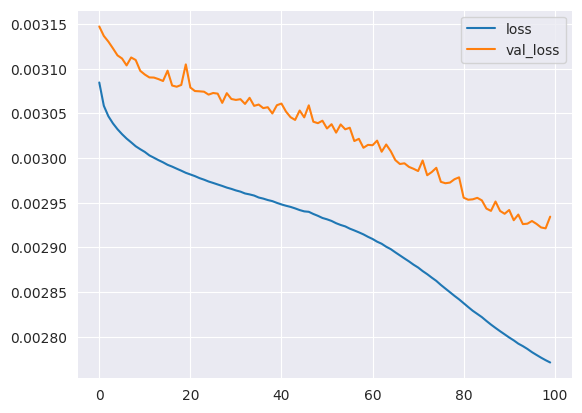

In [ ]:
gen_input.training = False
autoencoder.evaluate(gen_input)
plt.plot(ft_history.history['loss'], label='loss')
plt.plot(ft_history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
autoencoder.save(f"autoencoder_VAE_ft_{latent_size}_xception.h5")
encoder.save(f"encoder_VAE_ft_{latent_size}_xception.h5")
decoder.save(f"decoder_VAE_ft_{latent_size}_xception.h5")

In [ ]:
autoencoder = keras.models.load_model("autoencoder_VAE_ft_1024_xception.h5", custom_objects={"modified_mse": modified_mse})
encoder = keras.models.load_model("encoder_VAE_ft_1024_xception.h5")
decoder = keras.models.load_model("decoder_VAE_ft_1024_xception.h5")

In [ ]:
# with open("VAE_xception_full.json", "r") as j:
#     history_dict = json.load(j)

# gen_input.training = False
# autoencoder.evaluate(gen_input)
# plt.plot(history_dict['loss'], label='loss')
# plt.legend()
# plt.show()

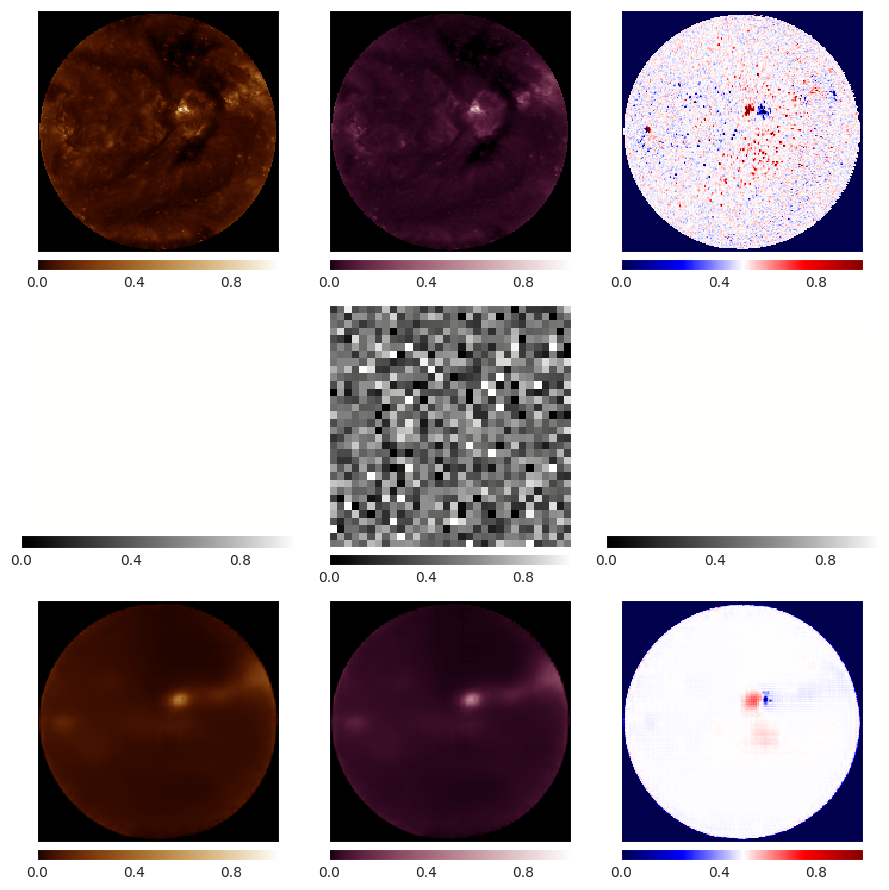

In [ ]:
test_img = all_gen_input.sample(1)
#code = encoder(test_img)
mean, var, code = encoder(test_img)
decoded = decoder(code)

test_img_channels = [i for i in test_img[0].transpose(2,0,1)]


code = (utils.square_dims_vector(np.asarray(code[0])) + 1)/2
code_img = [np.ones((3,4)), code, np.ones((3,4))]
                     
decoded_img_channels = [i for i in np.asarray(decoded[0]).transpose(2,0,1)]

isns.ImageGrid(
    test_img_channels+code_img+decoded_img_channels,
    cmap=["sdoaia193", "sdoaia211", "seismic"] + ["gray"]*3 + ["sdoaia193", "sdoaia211", "seismic"],
    orientation="h",
    vmin=0, 
    vmax=1
)

In [14]:
gen_input.take_all = True
dataset_dates = [datetime.datetime.strptime(i.stem, "%Y-%m-%dT%H-%M-%S") for i in gen_input.file_list]
dataset_dates

metadata = pd.DataFrame(columns=["datetime", "is_fast_wind", "CME"])
metadata["datetime"] = dataset_dates
metadata["datetime"] = metadata["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
metadata

,datetime,is_fast_wind,CME
0,2012-10-03 03:30:19,NaN,NaN
1,2012-10-03 04:06:22,NaN,NaN
2,2012-10-03 04:42:56,NaN,NaN
3,2012-10-03 05:19:13,NaN,NaN
4,2012-10-03 05:55:39,NaN,NaN
...,...,...,...
19007,2020-07-03 03:43:17,NaN,NaN
19008,2020-07-03 04:50:23,NaN,NaN
19009,2020-07-03 05:56:43,NaN,NaN
19010,2020-07-03 07:03:03,NaN,NaN


In [15]:
solar_wind_db = pd.read_csv("./omni_1hr_clean.csv")

solar_wind_db["is_fast_wind"] = (solar_wind_db["V"] > 550).astype(int)
solar_wind_db["datetime"] = pd.to_datetime(solar_wind_db["datetime"], format="%Y-%m-%d %H:%M:%S")
solar_wind_db = solar_wind_db[solar_wind_db["datetime"] >= min(dataset_dates)]
solar_wind_db["datetime"] = solar_wind_db["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")

solar_wind_db[solar_wind_db["is_fast_wind"] == 1].count()
solar_wind_db = solar_wind_db.dropna()
solar_wind_db

,datetime,BR,BT,BN,V,N,T,is_fast_wind
141772,2012-10-03 04:00:00,-3.3,-0.8,4.6,327.0,8.2,8305.0,0
141773,2012-10-03 05:00:00,-2.5,-0.1,4.5,325.0,10.4,11632.0,0
141774,2012-10-03 06:00:00,-2.4,0.2,3.0,327.0,7.8,16789.0,0
141775,2012-10-03 07:00:00,-0.3,-2.5,-0.4,327.0,8.0,19029.0,0
141776,2012-10-03 08:00:00,1.1,-1.8,-2.3,332.0,6.9,23107.0,0
...,...,...,...,...,...,...,...,...
222812,2021-12-31 20:00:00,-0.6,-2.0,4.2,418.0,7.8,78906.0,0
222813,2021-12-31 21:00:00,-1.3,-2.4,3.4,423.0,8.6,88405.0,0
222814,2021-12-31 22:00:00,1.1,-2.3,1.6,414.0,8.1,95631.0,0
222815,2021-12-31 23:00:00,4.6,-2.8,-3.8,388.0,5.0,68545.0,0


In [16]:
sw_dates = []
for index, row in solar_wind_db.iterrows():
    measurement_date = datetime.datetime.strptime(row["datetime"], "%Y-%m-%d %H:%M:%S")

    wind_delay = (ac.au / (row["V"] * (u.km/u.s))).decompose()
    wind_delay = datetime.timedelta(seconds=wind_delay.value)

    photo_delay = (ac.au / ac.c).decompose()
    photo_delay = datetime.timedelta(seconds=photo_delay.value)

    origin_date = measurement_date - wind_delay + photo_delay
    sw_dates.append(origin_date)

    # measurement_date = datetime.datetime.strptime(row["datetime"], "%Y-%m-%d %H:%M:%S")
    # origin_date = measurement_date
    # sw_dates.append(origin_date)

for idx, date_sw_str in tqdm(enumerate(metadata["datetime"]), total=len(metadata), desc="Creating fast solar wind dataframe"):
    date_sw = datetime.datetime.strptime(date_sw_str, "%Y-%m-%d %H:%M:%S")
    date_dist = [abs(date_sw - i) for i in sw_dates]
    if min(date_dist) < datetime.timedelta(hours=4):
        date_idx = date_dist.index(min(date_dist))
        metadata.at[idx, "is_fast_wind"] = solar_wind_db.iloc[date_idx]["is_fast_wind"]

    
metadata[metadata["is_fast_wind"] == 1]

# min([datetime.datetime.strptime(i.stem, "%Y-%m-%dT%H-%M-%S") for i in gen_input.file_list]), min([datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S") for i in metadata["datetime"]])
# min([i for i in gen_input.file_list]), min(metadata["datetime"])

Creating fast solar wind dataframe:   0%|          | 0/19012 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
cme_db = pd.read_csv("./CME_database.csv")

cme_db["CME Start"] = pd.to_datetime(cme_db["CME Start"], format="%Y-%m-%d %H:%M:%S")
cme_db = cme_db[cme_db["CME Start"] >= min(dataset_dates)]
cme_db["CME Start"] = cme_db["CME Start"].dt.strftime("%Y-%m-%d %H:%M:%S")

cme_db["CME End"] = pd.to_datetime(cme_db["CME End"], format="%Y-%m-%d %H:%M:%S")
cme_db = cme_db[cme_db["CME End"] <= max(dataset_dates)]
cme_db["CME End"] = cme_db["CME End"].dt.strftime("%Y-%m-%d %H:%M:%S")

cme_db

,CME Arrival,CME Start,CME End,V_CME (km/s)
396,2012-10-08 05:16:00,2012-10-08 18:00:00,2012-10-09 12:00:00,390.0
397,2012-10-12 19:00:00,2012-10-12 22:00:00,2012-10-13 10:00:00,490.0
398,2012-10-31 15:38:00,2012-11-01 00:00:00,2012-11-02 03:00:00,340.0
399,2012-11-09 03:00:00,2012-11-09 03:00:00,2012-11-09 15:00:00,370.0
400,2012-11-12 23:11:00,2012-11-13 08:00:00,2012-11-14 03:00:00,380.0
...,...,...,...,...
514,2019-05-26 22:14:00,2019-05-27 04:00:00,2019-05-28 00:00:00,350.0
515,2019-10-29 20:00:00,2019-10-29 20:00:00,2019-10-30 21:00:00,380.0
516,2019-11-11 06:00:00,2019-11-11 10:00:00,2019-11-12 12:00:00,360.0
517,2020-01-04 10:00:00,2020-01-04 10:00:00,2020-01-05 06:00:00,370.0


In [ ]:
start_dates = []
end_dates = []
for index, row in cme_db.iterrows():
    start_measurement_date = datetime.datetime.strptime(row["CME Start"], "%Y-%m-%d %H:%M:%S")
    end_measurement_date = datetime.datetime.strptime(row["CME End"], "%Y-%m-%d %H:%M:%S")

    wind_delay = (ac.au / (row["V_CME (km/s)"] * (u.km/u.s))).decompose()
    wind_delay = datetime.timedelta(seconds=wind_delay.value)

    photo_delay = (ac.au / ac.c).decompose()
    photo_delay = datetime.timedelta(seconds=photo_delay.value)

    start_date = start_measurement_date - wind_delay + photo_delay
    start_dates.append(start_date)

    end_date = end_measurement_date - wind_delay + photo_delay
    end_dates.append(end_date)

    # start_measurement_date = datetime.datetime.strptime(row["CME Start"], "%Y-%m-%d %H:%M:%S")
    # start_date = start_measurement_date - wind_delay + photo_delay
    # start_dates.append(start_date)

    # end_measurement_date = datetime.datetime.strptime(row["CME End"], "%Y-%m-%d %H:%M:%S")
    # end_date = end_measurement_date - wind_delay + photo_delay
    # end_dates.append(end_date)

for idx, date_sw_str in tqdm(enumerate(metadata["datetime"]), total=len(metadata), desc="Creating CME dataframe"):
    date_sw = datetime.datetime.strptime(date_sw_str, "%Y-%m-%d %H:%M:%S")
    in_range = np.any([(date_sw >= init_date) and (date_sw <= fin_date)  for init_date, fin_date in zip(start_dates, end_dates)])
    metadata.at[idx, "CME"] = in_range

metadata[metadata["CME"]]

Creating CME dataframe:   0%|          | 0/19012 [00:00<?, ?it/s]

,datetime,is_fast_wind,CME
17,2019-05-07 05:27:37,0,True
43,2015-06-23 04:45:18,0,True
68,2014-02-04 07:57:38,0,True
84,2017-03-31 04:43:07,0,True
133,2015-05-04 08:24:21,0,True
...,...,...,...
18925,2016-01-16 06:58:28,0,True
18928,2015-11-04 08:10:29,1,True
18971,2015-03-24 04:45:32,0,True
18982,2016-10-09 02:34:41,0,True


In [ ]:
metadata.to_csv("is_fast_solar_wind.csv")
metadata

,datetime,is_fast_wind,CME
0,2019-02-06 03:48:48,0,False
1,2020-01-27 02:30:16,0,False
2,2016-08-27 03:44:55,0,False
3,2020-04-20 03:45:40,0,False
4,2016-07-06 01:30:06,1,False
...,...,...,...
19007,2013-10-30 06:49:23,0,False
19008,2017-01-22 02:30:03,0,False
19009,2014-06-13 05:45:23,0,False
19010,2013-10-18 04:04:50,0,False


In [17]:
solar_wind_class = pd.read_csv("./is_fast_solar_wind.csv", index_col=0)
solar_wind_class = solar_wind_class.sort_values(by="datetime")
solar_wind_class["is_fast_wind"] = solar_wind_class["is_fast_wind"] == 1
solar_wind_class

,datetime,is_fast_wind,CME
14371,2012-10-03 03:30:19,False,False
4008,2012-10-03 04:06:22,False,False
15240,2012-10-03 04:42:56,False,False
5180,2012-10-03 05:19:13,False,False
16610,2012-10-03 05:55:39,False,False
...,...,...,...
12491,2020-07-03 03:43:17,False,False
17829,2020-07-03 04:50:23,False,False
9694,2020-07-03 05:56:43,False,False
165,2020-07-03 07:03:03,False,False


In [18]:
metadata[metadata["is_fast_wind"] == 1].count()

datetime        7
is_fast_wind    7
CME             0
dtype: int64

In [19]:
path = Path("encoded_images.npy")

if path.is_file():
    codes = np.load("encoded_images.npy")
else:
    latent_size = 1024
    codes = np.empty((len(all_gen_input.file_list), latent_size))
    for idx, val in tqdm(enumerate(all_gen_input), total=len(all_gen_input), desc="Encoding images"):
        codes[batch_size*idx:batch_size*(idx+1)] = encoder.predict(val[0], verbose=False)[2]

    np.save("encoded_images.npy", codes)

In [20]:
np.count_nonzero(~np.isinf(codes))/(codes.shape[0])

1024.0

In [21]:
dim_reducer = umap.UMAP(
    n_components=3, 
    n_neighbors=30,
    # metric='canberra', 
    metric='minkowski', 
    min_dist=0.2,
    verbose=True, 
    n_epochs=4000, 
    target_metric='euclidean',
    learning_rate=1.0,
    negative_sample_rate=20
)

In [22]:
dim_reducer.fit(codes)

UMAP(metric='minkowski', min_dist=0.2, n_components=3, n_epochs=4000, n_neighbors=30, negative_sample_rate=20, target_metric='euclidean', verbose=True)
Sun Jun 25 19:50:35 2023 Construct fuzzy simplicial set
Sun Jun 25 19:50:35 2023 Finding Nearest Neighbors
Sun Jun 25 19:50:35 2023 Building RP forest with 12 trees
Sun Jun 25 19:50:38 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Sun Jun 25 19:50:48 2023 Finished Nearest Neighbor Search
Sun Jun 25 19:50:50 2023 Construct embedding


Epochs completed:   0%|            0/4000 [00:00]

Sun Jun 25 19:53:00 2023 Finished embedding


UMAP(metric='minkowski', min_dist=0.2, n_components=3, n_epochs=4000, n_neighbors=30, negative_sample_rate=20, target_metric='euclidean', verbose=True)

In [23]:
display_all = True

if display_all:
    metadata_sample = metadata
    data_points = codes
else:
    sample_idx = random.sample(range(len(codes)), 1500)
    metadata_sample = metadata.iloc[sample_idx]
    data_points = codes[sample_idx]
    


projection = dim_reducer.transform(data_points)
projection.shape, projection.min(), projection.max()

((19012, 3), -9.131218, 17.950848)

In [24]:
point_cloud = projection

normals = (point_cloud - [np.mean(point_cloud, axis=0) for _ in point_cloud])
colors = (point_cloud + [[0.5,0.5,0.5] for _ in point_cloud])/1
print(colors)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:,:3])
pcd.colors = o3d.utility.Vector3dVector(colors)
pcd.normals = o3d.utility.Vector3dVector(normals)

# mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, .6)
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
    pcd, 
    depth=8, 
    width=0, 
    scale=1.1, 
    linear_fit=False
)[0]

mesh.compute_triangle_normals()
mesh.compute_vertex_normals()
bbox = pcd.get_axis_aligned_bounding_box()
p_mesh_crop = mesh.crop(bbox)

verts = np.asarray(mesh.vertices)
tris = np.asarray(mesh.triangles)


[[ 6.62963057  7.27480745  0.79073527]
 [ 6.60361338  7.27775002  0.80190241]
 [ 6.59769201  7.28637362  0.79639378]
 ...
 [ 3.94997811 -1.71737838 -0.98776877]
 [ 3.9612267  -1.72382092 -1.01541758]
 [ 3.98431277 -1.72820711 -1.00940192]]


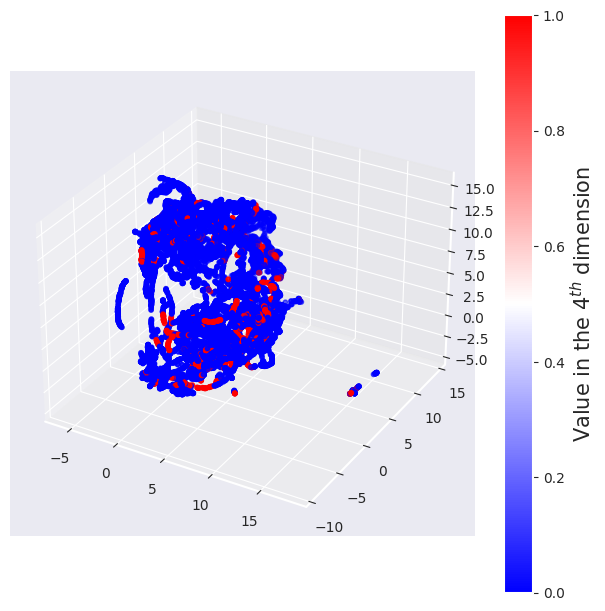

In [32]:
%matplotlib widget

# display_color = "CME"
display_color = "fast_wind"

display_styles = ['Scatter', '3D model', '3D and scatter']
# display_styles = ['3D model', 'Scatter', '3D and scatter']

style_selector = widgets.Dropdown(options=display_styles, description='Select display style')
style = style_selector.value

fig = None
ax = None
cbar = None

def make_plot(style):
    global ax, fig, cbar
    created_new = False
    if not ax or not fig:
        fig = plt.figure(figsize=(7.5, 7.5))
        ax = fig.add_subplot(111, projection='3d')
        created_new = True
    else:
        ax.clear()
        if cbar:
            cbar.remove()
    
    if style == '3D model' or style == '3D and scatter':
        ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=tris,
                            shade=True, alpha=.1, antialiased=False, linewidth=0)

    if style == 'Scatter' or style == '3D and scatter':
        if display_color == "CME":
            p = ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=solar_wind_class['CME'], 
                       s=1.0 if style == '3D and scatter' else 10.0, cmap="bwr")
        elif display_color == "fast_wind":
            p = ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=solar_wind_class['is_fast_wind'], 
                        s=1.0 if style == '3D and scatter' else 10.0, cmap="bwr")
        

        cbar = fig.colorbar(p);
        cbar.ax.set_ylabel('Predicted speed (km/s)')
        cbar.ax.set_ylabel('Value in the 4$^{th}$ dimension')
    
    if created_new:
        plt.show()
    
def on_style_change(change):
    global style
    style = change.new
    make_plot(style)

style_selector.observe(on_style_change, names='value')
display(widgets.HBox([style_selector]))
make_plot(style)
